In [1]:
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle
# import emcee

import xmeos
from xmeos import models
from xmeos import datamod

In [4]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [5]:
datamodel = analysis['datamodel']

In [ ]:
da

In [6]:
cmap = plt.get_cmap('RdBu')
plt.imshow(corr, cmap=cmap)
plt.clim(-1,1)
plt.colorbar()

NameError: name 'corr' is not defined

<IPython.core.display.Javascript object>


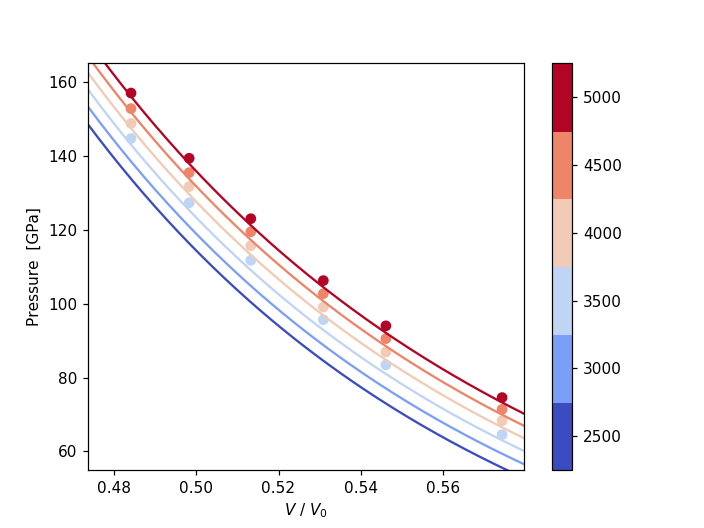

In [8]:
eos_mod = datamodel['eos_mod']
tbl = datamodel['data']['table']
Tlbl = data['T_labels']
delT = Tlbl[1]-Tlbl[0]


cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]
V0 = params['V0']

Vmod = V0*np.linspace(.4,1.1,1001)


plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.press(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['P'],c=tbl['T'], cmap=cmap)
plt.clim(clims)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(Tlbl)



<IPython.core.display.Javascript object>


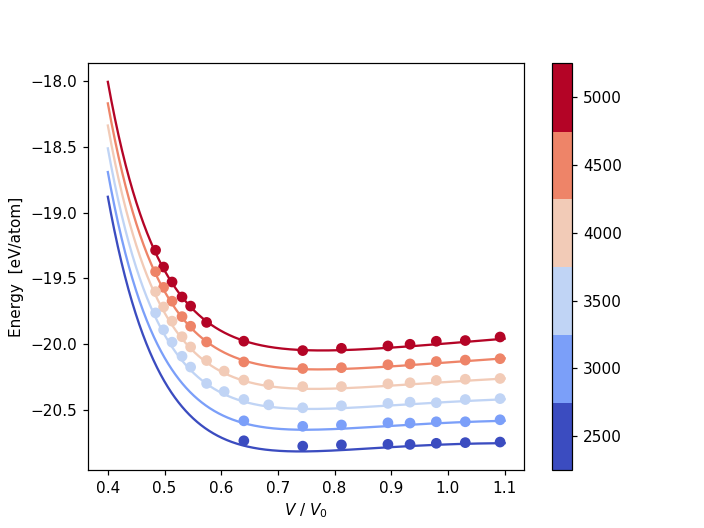

In [10]:
plt.figure()
for iT in Tlbl:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod/V0, eos_mod.internal_energy(Vmod,iT), '-', color=icol)
    
plt.scatter(tbl['V']/V0,tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'$V$ / $V_0$')
plt.ylabel(r'Energy  [eV/atom]')
plt.colorbar()
plt.clim(clims)
cbar.set_ticks(Tlbl)